In [249]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [250]:
sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/gp_fusion')


In [251]:
from modules.data_handling import load_data, load_and_normalize_data
from modules.model_training import train_and_predict_single_gp
from modules.model_training import GPModel, to_torch
from modules.fusion_methods import product_fusion
from modules.fusion_methods import compute_neg_log_like


import torch
from tqdm import tqdm

from gpytorch.means import ZeroMean
from gpytorch.kernels import AdditiveStructureKernel, RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.metrics import mean_standardized_log_loss




In [267]:
# ------------ Load and normalize data --------- #
dataset_name = "autos"
# dataset_name = "breastcancer"

split=0
X_train, y_train, X_test, y_test, y_std = load_data(dataset_name,split,)

print('input dim: ', X_train.shape[1])
print("training size: ", len(y_train))
print("test size: ", len(y_test))

input dim:  24
training size:  144
test size:  15


In [268]:
# check that the entire dataset has zero mean (I didn't do this, but Trevor :-))
print(np.mean(np.vstack([X_train,X_test]),axis=0))
print(np.mean(np.concatenate([y_train,y_test]),axis=0))

# I did normalize the intputs and outputs to have unit variance
print(np.std(np.vstack([X_train,X_test]),axis=0))
print(np.std(np.concatenate([y_train,y_test]),axis=0))

[ 1.63930854e-05  2.37138165e-06  1.15270825e-05  1.29099445e-06
  3.51763235e-06 -8.72081599e-06  6.12994837e-06  6.03475016e-06
 -5.31113006e-06 -4.72182186e-06  1.41440516e-05 -8.71014121e-06
  4.29387139e-07  1.30303597e-06  6.78165922e-06  8.92713126e-06
 -1.77088659e-05 -1.33294018e-05  3.28627486e-06  7.92884062e-06
  1.14154070e-05 -5.14751347e-06  1.80051111e-06 -8.41591323e-06]
1.0397028718051562e-07
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.0


In [269]:
# Fit a GP with ARD-RBF kernel as the baseline

test_preds, train_preds = train_and_predict_single_gp(X_train,y_train,X_test,X_train,
                            kappa=2,lambdaa=2,
                            mean=ZeroMean(),  # we don't want to use the mean of y_train as prior mean (using ConstantMean())
                            lr=0.1,
                            training_iter=1000,
                            initialiaze_hyper=False,  # if false, kappa and lambdaa are not used for initializing the hyperparameter
                            )

# compute the negative log-likelihood (log-loss) on test data:
print("nlpd train:", mean_standardized_log_loss(train_preds, torch.from_numpy(y_train)).numpy())
print("nlpd test:", mean_standardized_log_loss(test_preds, torch.from_numpy(y_test)).numpy())

# equivalently:
print(compute_neg_log_like(train_preds.mean.numpy(),
                           np.sqrt(train_preds.variance).numpy(),
                           y_train))
print(compute_neg_log_like(test_preds.mean.numpy(),
                           np.sqrt(test_preds.variance).numpy(),
                           y_test))

print("rmse train: ", np.sqrt(np.mean((y_train - train_preds.mean.numpy())**2)))
print("rmse test: ", np.sqrt(np.mean((y_test - test_preds.mean.numpy())**2)))

nlpd train: -0.3112354044171718
nlpd test: 0.36357568615948566
[-0.31123542]
[0.36357566]
rmse train:  0.15660076574032322
rmse test:  0.3248683028385435


In [270]:
# Let us do the check that we get the same results when we train and predict using the functions:
# train_expert and predict_with_expert
from modules.model_training import train_expert, predict_with_expert


model,likelihood = train_expert(X_train,y_train,
                                kappa=2,lambdaa=2,
                                mean=ZeroMean(),
                                lr=0.1,
                                training_iter=1000,
                                initialize_hyper=False,
                                )

mean_preds,std_preds,_ = predict_with_expert(model,likelihood,X_test)

print(compute_neg_log_like(mean_preds,std_preds,y_test))

[0.36357566]


Let's average results

In [20]:

nlpd = []
rmse = []
for i in tqdm(range(10)):
    try:
        X_train, y_train, X_test, y_test, y_std = load_data(dataset_name,i)

        # # With load_and_normalize_data fun the data is normalized using the training data only
        # X_train, y_train, X_test, y_test = load_and_normalize_data(dataset_name,i,
        #                                                         normalize_y=True,  
        #                                                         normalize_x_method="max-min")

        test_preds, _ = train_and_predict_single_gp(X_train,y_train,X_test,X_test,
                                kappa=2,lambdaa=2,
                                mean=ZeroMean(),  # we don't want to use the mean of y_train as prior mean
                                lr=0.1,
                                training_iter=500,
                                initialiaze_hyper=False, # if false, kappa and lambdaa don't matter!
                                )
        nlpd_now = compute_neg_log_like(test_preds.mean,np.sqrt(test_preds.variance),y_test)

        rmse_now = np.sqrt(np.mean((test_preds.mean.numpy() - y_test)**2))

        nlpd.append(nlpd_now.squeeze())
        rmse.append(rmse_now)
    except:
        print("There was an error during hyperparameter learning.")


nlpd = np.array(nlpd)
rmse = np.array(rmse)

100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


In [21]:
nlpd

array([ 0.39663261,  0.62069608, -0.03275486,  0.37309431,  0.07089072,
       -0.0375203 ,  0.16635601,  0.05886923,  0.07811722,  0.44992557])

In [19]:
nlpd

array([ 0.50446794,  0.72029356,  0.05992493,  0.32965062,  0.11765238,
       -0.02974258,  0.13023134,  0.1442318 ,  0.1408854 ,  0.37034965])

In [22]:
nlpd.mean(),nlpd.std()

(0.21443065877592962, 0.21660025837568553)

In [23]:
rmse.mean(), rmse.std()

(0.3399892426555571, 0.1665370674345152)

## Let's try using an additive kernel

In [24]:
'''
AdditiveStructureKernel computes d one-dimensional kernels (using the supplied base_kernel), 
and then adds the component kernels together.
"AdditiveStructureKernel is deprecated, and will be removed in GPyTorch 2.0. "
'Please refer to the "Kernels with Additive or Product Structure" tutorial '
"in the GPyTorch docs for how to implement GPs with additive structure."
'''
kernel = AdditiveStructureKernel(base_kernel=ScaleKernel(RBFKernel()), num_dims=X_train.shape[1])

nlpd = []
rmse = []
for i in tqdm(range(10)):
    # try:
        X_train, y_train, X_test, y_test, y_std = load_data(dataset_name,i)

        # # With load_and_normalize_data fun the data is normalized using the training data only
        # X_train, y_train, X_test, y_test = load_and_normalize_data(dataset_name,i,
        #                                                         normalize_y=True,  
        #                                                         normalize_x_method="max-min")

        test_preds, _ = train_and_predict_single_gp(X_train,y_train,X_test,X_test,
                                kappa=2,lambdaa=2,
                                mean=ZeroMean(),  # we don't want to use the mean of y_train as prior mean
                                kernel=kernel,
                                lr=0.1,
                                training_iter=100,
                                initialiaze_hyper=False, # if False, kappa and lambdaa are not used for initializing the hyperparameters; we just use the default values.
                                )
        nlpd_now = compute_neg_log_like(test_preds.mean,np.sqrt(test_preds.variance),y_test)

        rmse_now = np.sqrt(np.mean((test_preds.mean.detach().numpy() - y_test)**2))

        nlpd.append(nlpd_now.squeeze())
        rmse.append(rmse_now)
    # except:
    #     print("There was an error during hyperparameter learning.")


nlpd = np.array(nlpd)
rmse = np.array(rmse)

100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


In [25]:
nlpd

array([0.34137439, 0.6400602 , 0.37289921, 0.16129038, 0.13417607,
       0.04016093, 0.02746184, 0.02168028, 0.0959663 , 0.19244998])

In [26]:
nlpd.mean(),nlpd.std()

(0.20275195698146095, 0.18635589889484833)

In [27]:
rmse.mean(), rmse.std()

(0.3100164964961764, 0.08046684862617143)

In [28]:
%%script true
kernel = ScaleKernel(AdditiveStructureKernel(base_kernel=RBFKernel(), num_dims=X_train.shape[1]))
model = GPModel(to_torch(X_train),
                to_torch(y_train),
                GaussianLikelihood(),
                kernel=kernel,mean=ZeroMean())
for name, param in model.named_parameters():
    print(f'Parameter name: {name:42} value = {param.item():1.2f}')

## Stack GPs built on 1d projections:

We'll use the axis-aligned 1d projections for the moment, since I think it's the one
"closer" to using the additive kernel of one-dimensional kernels

In [62]:
nlpd = []
rmse = []

# proj = "axis"
proj = "random"

for split in tqdm(range(10)):
        X_train, y_train, X_test, y_test, y_std = load_data(dataset_name,split)

        mean_experts = []
        std_experts = []
        std_experts_prior = []
        for d in range(X_train.shape[1]):  # as many projections as dimension of X
            if proj == "random":
                  np.random.seed(d)
                  P_proj = np.random.randn(X_train.shape[1],1)
            elif proj == "axis":
                  index = d
                  P_proj = np.array([1.0 if i == index else 0.0 for i in range(X_train.shape[1])])
                  P_proj = P_proj.reshape(-1,1)

            # test_preds, _ = train_and_predict_single_gp(
            #                         np.matmul(X_train,P_proj),
            #                         y_train,
            #                         np.matmul(X_test,P_proj),
            #                         np.matmul(X_test,P_proj),
            #                         mean=ZeroMean(),  # we don't want to use the mean of y_train as prior mean
            #                         lr=0.1,
            #                         training_iter=100,
            #                         initialiaze_hyper=False, # if False, kappa and lambdaa are not used for initializing the hyperparameters; we just use the default values.
            #                         )

            # mean_experts.append(test_preds.mean.numpy())
            # std_experts.append(np.sqrt(test_preds.variance.numpy()))
      
            model,likelihood = train_expert(np.matmul(X_train,P_proj),
                                            y_train,
                                            kappa=2,lambdaa=2,
                                            mean=ZeroMean(),
                                            lr=0.1,
                                            training_iter=100,
                                            initialize_hyper=False,
                                          )

            mean_preds,std_preds,std_preds_prior = predict_with_expert(model,
                                                                       likelihood,
                                                                       np.matmul(X_test,P_proj))

            mean_experts.append(mean_preds)
            std_experts.append(std_preds)
            std_experts_prior.append(std_preds_prior)


        mean_experts = np.stack(mean_experts,axis=-1)
        std_experts = np.stack(std_experts,axis=-1)
        std_experts_prior = np.stack(std_experts_prior,axis=-1)

        # Fuse one-dimensional experts' predictions
        mean_fused, std_fused, _ = product_fusion(mean_experts,
                                                  std_experts,
                                                  std_experts_prior,
                                                  weighting="entropy",
                                                #   weighting="uniform",
                                                #   weighting="no-weights",
                                                  normalize=True,
                                                #   method = "PoE",
                                                  method = "gPoE",
                                                  )
        
        nlpd_now = compute_neg_log_like(mean_fused,std_fused,y_test)
        nlpd.append(nlpd_now.squeeze())

        rmse_now = np.sqrt(np.mean( (mean_fused-y_test)**2 ))
        rmse.append(rmse_now)
        
nlpd = np.array(nlpd)
rmse = np.array(rmse)


100%|██████████| 10/10 [00:32<00:00,  3.21s/it]


In [63]:
nlpd.mean(), nlpd.std()

(1.0256066997598272, 0.18867332271951584)

In [64]:
rmse.mean(), rmse.std()

(1.0401042721707483, 0.24550736643944826)

## Delbridge's repository

In [65]:
sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/Randomly-Projected-Additive-GPs')


In [ ]:
from fitting.optimizing import train_to_convergence

In [ ]:
from gpytorch.mlls import ExactMarginalLogLikelihood

likelihood = GaussianLikelihood()
model = GPModel(to_torch(X_train),to_torch(y_train),likelihood)

print(model.covar_module.base_kernel.lengthscale)
print(likelihood.noise_covar.noise)


mll = ExactMarginalLogLikelihood(model.likelihood, model)
max_iter = train_to_convergence(model, 
                     to_torch(X_train), 
                     to_torch(y_train),
                     optimizer=torch.optim.Adam, objective=mll, 
                     max_iter=100, print_freq=1, verbose=0,lr = 0.1)
max_iter

In [ ]:
print(model.covar_module.base_kernel.lengthscale)
print(likelihood.noise_covar.noise)

In [ ]:
model.eval()
test_preds = likelihood(model(to_torch(X_test)))

print(mean_standardized_log_loss(test_preds,to_torch(y_test)))

I want to try now the function create_exact_gp

In [66]:
from training_routines import train_exact_gp

In [67]:
model_args = {'ard': True, 'ski': False, 'grid_size': None, 'kernel_type': 'RBF', 
              'init_lengthscale_range': (0.1, 1.0), 'keops': False,
              'noise_prior': False, 'init_noise_range': (0.1,1),
              }
train_args = {'lr': 0.1, 'max_iter': 100, 'verbose': 0, 'patience': 20,
              'conv_tol': 1e-4, 'check_conv': True, 'smooth': True,
              'batch_size': None, 'checkpoint': False, 'print_freq': 1,
              'random_restarts': 5, 'optimizer': 'adam',
              }

model_metrics, pred_mean, model = train_exact_gp(trainX = to_torch(X_train), 
                                                 trainY = to_torch(y_train), 
                                                 testX = to_torch(X_test), 
                                                 testY = to_torch(y_test), 
                                                 kind = 'full', 
                                                 model_kwargs = model_args, 
                                                 train_kwargs = train_args,
                                                 )

/Users/fllorente/Dropbox/con_Petar/PYTHON/Randomly-Projected-Additive-GPs/fitting/optimizing.py:81: RuntimeWarning: Mean of empty slice.
  ma[i] = losses[i-patience+1:i+1].mean()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [68]:
model_metrics["prior_train_nmll"], model_metrics["train_nll"]

(0.31298235058784485, -0.26062139868736267)

In [69]:
mean_standardized_log_loss(model.likelihood(model(to_torch(X_train))),
                           to_torch(y_train))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


tensor(-0.2856, grad_fn=<MeanBackward1>)

In [71]:
from gpytorch.mlls import ExactMarginalLogLikelihood
print(model_metrics["test_nll"]) # creo que esta mal calculado...
'''
esta usando mll = GaussianLogMarginalLikelihood para calcular este valor...
por lo que estaria calculando la log-pdf de la Gaussian multivariate, en lugar de la
media de las log-pdf de las Gaussianas univariantes.
'''

mll = ExactMarginalLogLikelihood(model.likelihood, model)
mll.eval()
aux =model(to_torch(X_test))
print(-mll(aux,to_torch(y_test)).detach().numpy())


# deberia ser igual a esto pero no...
aux = model.likelihood(model(to_torch(X_test)))

from scipy.stats import multivariate_normal

print(
    -multivariate_normal.logpdf(y_test, 
                           aux.mean.detach().numpy(),
                           aux.covariance_matrix.detach().numpy(),
                           )
)

# este valor coincide con
print(-aux.log_prob(to_torch(y_test)).detach().numpy())

0.40473681688308716
0.40473878
6.4758219587159775
6.4758205


In [72]:
# este es el que me interesa
with torch.no_grad():
    print(mean_standardized_log_loss(model.likelihood(model(to_torch(X_test))),
                           to_torch(y_test)))

tensor(0.4342)


In [73]:
pred_mean

tensor([-0.3860, -0.5637, -1.0533,  0.7636,  0.1275, -1.1920, -1.1596,  1.1078,
        -0.9683, -1.0333, -0.0197, -0.4215, -0.3481,  0.4283, -1.2783, -0.4357])

In [74]:
model.likelihood(model(to_torch(X_test))).mean

tensor([-0.3860, -0.5637, -1.0533,  0.7636,  0.1275, -1.1920, -1.1596,  1.1078,
        -0.9683, -1.0333, -0.0197, -0.4215, -0.3481,  0.4283, -1.2783, -0.4357],
       grad_fn=<ViewBackward0>)

## rff-based pogpe without weights 


In [271]:
import numpyro
from numpyro.infer import NUTS, MCMC, SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoDelta, AutoNormal

from optax import adam, chain, clip

from numpyro import distributions as dist
import jax
import jax.numpy as jnp
import jax.random as random



matmul_vmapped = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))

def pogpe_with_RFGP_fixed_Omega(X, M=None, S = 50, Y=None, y_test=None):              # M is the number of experts
    N = X.shape[0]
    DIM = X.shape[1]
    
    Omega_fixed = jax.random.normal(jax.random.PRNGKey(30), (S, DIM))

    #########################
    # RF-GP for the experts #
    #########################
    with numpyro.plate("M", M, dim=-2):
        var_mu_ex = numpyro.sample("kernel_var_exp_mean", dist.HalfNormal(1.0))
        # noise_mu_ex = numpyro.sample("kernel_noise_exp_mean", dist.InverseGamma(5.0, 5.0))
        std_ex_un = numpyro.sample('std_ex_un', dist.InverseGamma(5.0, 5.0))
        std_ex = numpyro.deterministic('std_ex', jnp.tile(jnp.reshape(std_ex_un, (-1, 1)), N))

        with numpyro.plate('2S', 2*S):
            theta_mu_ex = numpyro.sample("theta_mu_ex", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            
        with  numpyro.plate('DIM', DIM):
            lengthscale_ex = numpyro.sample('ell_ex', dist.HalfNormal(scale = 1))

            
    assert lengthscale_ex.shape == (M,DIM)
    assert Omega_fixed.shape == (S,DIM)

    #### OMEGA FIXED
    vdivide =  jax.vmap(lambda x, y: jnp.divide(x, y), (None, 0))                                                                                                                            
    Omega_ex = vdivide( Omega_fixed, lengthscale_ex)     # shape = (M,S,DIM)
    ########
    assert Omega_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(Omega_ex, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    #assert ola.shape == (M,N,S)
    Phi_ex = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_ex = 1/jnp.sqrt(S)*Phi_ex  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi_ex.shape == (M, N, 2*S)
    assert std_ex.shape == (M,N)
    assert theta_mu_ex.shape == (M,2*S)

    # theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex+ noise_mu_ex),2*S) * theta_mu_ex
    theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex),2*S) * theta_mu_ex
    mu_ex = numpyro.deterministic("mu_ex", matmul_vmapped(Phi_ex,theta_mu_ex) )                 # shape = (M,Ndata)
    assert mu_ex.shape == (M,N)



    # #########################
    # # RF-GP for log weights #
    # #########################
    # with numpyro.plate("M", M, dim=-2):
    #     # set uninformative log-normal priors on our three kernel hyperparameters
    #     var_logw = numpyro.sample("kernel_var_logw", dist.HalfNormal(1.0))
    #     # noise_logw = numpyro.sample("kernel_noise_logw", dist.InverseGamma(5.0, 5.0))

    #     with numpyro.plate('2S', 2*S):
    #         theta_logw = numpyro.sample("theta_logw", dist.Normal(loc=0.0, 
    #                                                     scale=1.0)) # I'm not considering signal power here!
            
    #     with numpyro.plate("DIM", DIM):
    #         lengthscale_logw = numpyro.sample('ell_logw', dist.HalfNormal(scale = 1.0))

    # assert lengthscale_logw.shape == (M,DIM)

    # # theta_logw = jnp.tile(jnp.sqrt(var_logw+ noise_logw),2*S) * theta_logw
    # theta_logw = jnp.tile(jnp.sqrt(var_logw),2*S) * theta_logw
    # assert theta_logw.shape == (M,2*S)


    # Omega_logw = vdivide( Omega_fixed, lengthscale_logw)     # shape = (M,S,DIM)
    # ola = X @ jnp.transpose(Omega_logw, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)

    # Phi_logw = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    # Phi_logw = 1/jnp.sqrt(S)*Phi_logw  # se me habia olvidado dividir entre jnp.sqrt(S)

    # logw = numpyro.deterministic("logw", matmul_vmapped(Phi_logw, theta_logw) - jnp.log(M))   # PRIOR MEAN FUNCTION!
    # assert logw.shape == (M,N)


    ################################################
    # Fuse with generalized multiplicative pooling #
    ################################################
    # w = numpyro.deterministic("w", jnp.exp(logw) )                 # shape = (M,Ndata)
    w = numpyro.deterministic("w", jnp.ones((M,N)))  # All weights are one (not trained)
    w  = w.T
    tau_ex = 1. / std_ex


    tau_fused = numpyro.deterministic(
        "tau_fused", jnp.einsum("nm,mn->m", tau_ex, w)
    )  # N,
    assert tau_fused.shape == (N,)

    mu_fused = numpyro.deterministic(
        "mean_fused", jnp.einsum("nm,nm,mn->m", tau_ex, mu_ex, w) / tau_fused
    )  # N,
    assert mu_fused.shape == (N,)
    
    std_fused = numpyro.deterministic("std_fused", 1 / jnp.sqrt(tau_fused))
    assert std_fused.shape == (N,)

    # noise = numpyro.sample("noise", dist.HalfNormal(scale = 1))

    numpyro.sample(
        "y_val",
        dist.Normal(loc=jnp.squeeze(mu_fused), 
                    scale=jnp.squeeze(std_fused),
                    # scale=jnp.sqrt(jnp.squeeze(std_fused)**2 + noise),
                    ),
        obs=Y,
    )

    if y_test is not None:
        # compute the lpd of the observations
        numpyro.deterministic("lpd_point", jax.scipy.stats.norm.logpdf(
                jnp.squeeze(y_test), loc=jnp.squeeze(mu_fused), scale=jnp.squeeze(std_fused),
                )
            )

In [280]:
M_models = 2
num_spectral_freqs = 100


svi= SVI(
        pogpe_with_RFGP_fixed_Omega,
        AutoDelta(pogpe_with_RFGP_fixed_Omega, 
                  # init_loc_fn = numpyro.infer.initialization.init_to_median,
                  init_loc_fn = numpyro.infer.init_to_sample,
                  ),
        # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam
        optim=chain(clip(10.0), adam(0.005)),
        # optim = numpyro.optim.Adam(0.1),
        loss=Trace_ELBO(),
    )

print("===== Pogpe =====")
print("starting svi...")
res = svi.run(
    jax.random.PRNGKey(3),
    # 5,
    300,  # these many iterations when using adam optimizer
    X=X_train,
    Y=y_train,
    M=M_models,
    S=num_spectral_freqs,
)

print('done!')


params = res.params
guide = AutoDelta(pogpe_with_RFGP_fixed_Omega)
# use guide to make predictive
dist_posterior_predictive = Predictive(model=pogpe_with_RFGP_fixed_Omega, 
                                       guide=guide, params=params, num_samples=1)

# these are not actual samples but just the MAP estimates (since we are using AutoDelta)
samples_posterior_predictive = dist_posterior_predictive(jax.random.PRNGKey(3), 
                                                         X=X_train, 
                                                         Y=None, 
                                                         M=M_models,
                                                         S=num_spectral_freqs,
                                                         y_test=y_train)
ymu_tr_svi = samples_posterior_predictive["mean_fused"].mean(0)
w_tr = samples_posterior_predictive["w"].mean(0)

lpd_pogpe_svi_train = samples_posterior_predictive["lpd_point"].mean()
rmse_pogpe_svi_train = np.sqrt(np.mean((ymu_tr_svi-y_train)**2))

samples_posterior_predictive = dist_posterior_predictive(jax.random.PRNGKey(3), 
                                                         X=X_test, 
                                                         Y=None, 
                                                         M=M_models,
                                                         S=num_spectral_freqs,
                                                         y_test=y_test)
ymu_tst_svi = samples_posterior_predictive["mean_fused"].mean(0)
w_tst = samples_posterior_predictive["w"].mean(0)

lpd_pogpe_svi_test = samples_posterior_predictive["lpd_point"].mean()
rmse_pogpe_svi_test = np.sqrt(np.mean((ymu_tst_svi-y_test)**2))



print("nlpd train: ", -lpd_pogpe_svi_train)
print("nlpd test: ", -lpd_pogpe_svi_test)

print("rmse train: ", rmse_pogpe_svi_train)
print("rmse test: ", rmse_pogpe_svi_test)


===== Pogpe =====
starting svi...


100%|██████████| 300/300 [00:00<00:00, 430.82it/s, init loss: 855.1451, avg. loss [286-300]: 481.1580]


done!
nlpd train:  0.17651628259390514
nlpd test:  3.189712249770881
rmse train:  0.14329776078904655
rmse test:  1.1205262502374091


In [281]:
samples_posterior_predictive["std_ex"]

Array([[[0.30626809, 0.30626809, 0.30626809, 0.30626809, 0.30626809,
         0.30626809, 0.30626809, 0.30626809, 0.30626809, 0.30626809,
         0.30626809, 0.30626809, 0.30626809, 0.30626809, 0.30626809],
        [0.61943315, 0.61943315, 0.61943315, 0.61943315, 0.61943315,
         0.61943315, 0.61943315, 0.61943315, 0.61943315, 0.61943315,
         0.61943315, 0.61943315, 0.61943315, 0.61943315, 0.61943315]]],      dtype=float64)

In [282]:
# without weights, the fused model has constant variance...
samples_posterior_predictive["std_fused"]

Array([[0.45270227, 0.45270227, 0.45270227, 0.45270227, 0.45270227,
        0.45270227, 0.45270227, 0.45270227, 0.45270227, 0.45270227,
        0.45270227, 0.45270227, 0.45270227, 0.45270227, 0.45270227]],      dtype=float64)

In [283]:
%%script true
plt.plot(res[2])

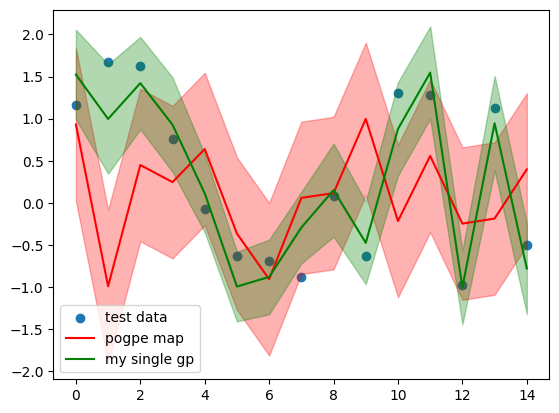

In [284]:
plt.scatter(range(len(X_test)),y_test, label = "test data")
plt.plot(ymu_tst_svi,label = "pogpe map",color="red")
plt.fill_between(range(len(X_test)),ymu_tst_svi+2*samples_posterior_predictive["std_fused"].mean(0),
                 ymu_tst_svi-2*samples_posterior_predictive["std_fused"].mean(0),alpha=0.3,color="red")
plt.plot(test_preds.mean.numpy(), label = "my single gp",color="green")
plt.fill_between(range(len(X_test)),test_preds.mean.numpy()+2*np.sqrt(test_preds.variance.numpy()),
                 test_preds.mean.numpy()-2*np.sqrt(test_preds.variance.numpy()),alpha=0.3,color="green")

plt.legend();

In [238]:
%%script true
for i in range(M_models):
    plt.plot(samples_posterior_predictive["w"].mean(0)[i,:])

In [239]:
%%script true
numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")
# numpyro.enable_x64()


# %% POGPEEEEE (MCMC)

new_dict = {}
for key, value in params.items():
    # print(key)
    new_key = key.replace("_auto_loc","")
    new_dict[f"{new_key}"] = value


miMCMC = NUTS(
    pogpe_with_RFGP_fixed_Omega,
    # max_tree_depth=2,
    # max_tree_depth=(10, 5),
    max_tree_depth=(5, 5),
    # find_heuristic_step_size=True,
    # init_strategy=numpyro.infer.initialization.init_to_median,
    init_strategy = numpyro.infer.initialization.init_to_value(values=new_dict),
)

fer = MCMC(
    miMCMC,
    num_chains=4,
    num_samples=500,
    num_warmup=500,
    thinning=1,
    progress_bar=True,
    chain_method="parallel",
)

print("starting MCMC...")
fer.run(
    jax.random.PRNGKey(3),
    X_train,
    Y=y_train,
    y_test=y_train,  # this is line is for computing the lpd of y_train
    M=M_models,
    S=num_spectral_freqs,
)

print('MCMC done!')

miSamples = fer.get_samples()


predict = numpyro.infer.Predictive(pogpe_with_RFGP_fixed_Omega, miSamples)
preds = predict(
    jax.random.PRNGKey(3),
    X_test,
    Y=None,
    M=M_models,
    y_test=y_test,  # this line is for computing the lpd of y_test
    S = num_spectral_freqs,
)




In [240]:
%%script true

lpd_pogpe_mcmc_train = np.mean(
    jax.nn.logsumexp(miSamples["lpd_point"], axis=0) - np.log(
    miSamples["lpd_point"].shape[0]
)
)

lpd_pogpe_mcmc_test = np.mean(
    jax.nn.logsumexp(preds["lpd_point"], axis=0) - np.log(
    preds["lpd_point"].shape[0]
)
)

ymu_tr_pogpe = miSamples["mean_fused"].mean(0)
ymu_tst_pogpe = preds["mean_fused"].mean(0)

rmse_pogpe_mcmc_train = np.sqrt(np.mean((ymu_tr_pogpe-y_train)**2))
rmse_pogpe_mcmc_test = np.sqrt(np.mean((ymu_tst_pogpe-y_test)**2))


print("nlpd train: ", -lpd_pogpe_mcmc_train)
print("nlpd test: ", -lpd_pogpe_mcmc_test)


print("rmse train: ", rmse_pogpe_mcmc_train)
print("rmse test: ", rmse_pogpe_mcmc_test)

In [241]:
%%script true
miSamples["std_fused"].mean(0)

## alternative rff-based pogpe without weights

In [242]:
import numpyro
from numpyro.infer import NUTS, MCMC, SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoDelta, AutoNormal

from optax import adam, chain, clip

from numpyro import distributions as dist
import jax
import jax.numpy as jnp
import jax.random as random



matmul_vmapped = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))

def my_pogpe(X, M=None, S = 50, Y=None, y_test=None):              # M is the number of experts
    N = X.shape[0]
    DIM = X.shape[1]
    
    Omega_fixed = jax.random.normal(jax.random.PRNGKey(30), (S, DIM))

    assert Omega_fixed.shape == (S,DIM)

    #########################
    # RF-GP for the experts #
    #########################
    with numpyro.plate("M", M, dim=-2):
        var_mu_ex = numpyro.sample("kernel_var_exp_mean", dist.HalfNormal(1.0))
        var_logstd_ex = numpyro.sample("kernel_var_exp_logstd", dist.HalfNormal(1.0))

        with numpyro.plate('2S', 2*S):
            theta_mu_ex = numpyro.sample("theta_mu_ex", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            theta_logstd_ex = numpyro.sample("theta_logstd_ex", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            
        with  numpyro.plate('DIM', DIM):
            lengthscale_mu_ex = numpyro.sample('ell_ex', dist.HalfNormal(scale = 1))
            lengthscale_logstd_ex = numpyro.sample('ell_logstd_ex', dist.HalfNormal(scale = 1))

            
    assert lengthscale_mu_ex.shape == (M,DIM)
    assert lengthscale_logstd_ex.shape == (M,DIM)
    assert theta_mu_ex.shape == (M,2*S)
    assert theta_logstd_ex.shape == (M,2*S)

    #### OMEGA FIXED
    vdivide =  jax.vmap(lambda x, y: jnp.divide(x, y), (None, 0))       
    #
    # =============== EXPERTS' MEANS  =============== #                                                                                                                   
    Omega_mu_ex = vdivide( Omega_fixed, lengthscale_mu_ex)     # shape = (M,S,DIM)
    assert Omega_mu_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(Omega_mu_ex, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    #assert ola.shape == (M,N,S)
    Phi_mu_ex = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_mu_ex = 1/jnp.sqrt(S)*Phi_mu_ex  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi_mu_ex.shape == (M, N, 2*S)
    #
    theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex),2*S) * theta_mu_ex
    mu_ex = numpyro.deterministic("mu_ex", matmul_vmapped(Phi_mu_ex,theta_mu_ex) )    
    assert mu_ex.shape == (M,N)
    # ========================================== #

    # =============== EXPERTS' LOGSTDS  =============== #                                                                                                                   
    Omega_logstd_ex = vdivide( Omega_fixed, lengthscale_logstd_ex)     # shape = (M,S,DIM)
    assert Omega_logstd_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(Omega_logstd_ex, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    #assert ola.shape == (M,N,S)
    Phi_logstd_ex = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_logstd_ex = 1/jnp.sqrt(S)*Phi_logstd_ex  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi_logstd_ex.shape == (M, N, 2*S)
    #
    theta_logstd_ex = jnp.tile(jnp.sqrt(var_logstd_ex),2*S) * theta_logstd_ex
    logstd_ex = numpyro.deterministic("logstd_ex", matmul_vmapped(Phi_logstd_ex,theta_logstd_ex) )   
    std_ex =  numpyro.deterministic("std_ex", jnp.exp(logstd_ex) )
    assert logstd_ex.shape == (M,N)
    assert std_ex.shape == (M,N)
    # ========================================== #



    # #########################
    # # RF-GP for log weights #
    # #########################
    # with numpyro.plate("M", M, dim=-2):
    #     # set uninformative log-normal priors on our three kernel hyperparameters
    #     var_logw = numpyro.sample("kernel_var_logw", dist.HalfNormal(1.0))
    #     # noise_logw = numpyro.sample("kernel_noise_logw", dist.InverseGamma(5.0, 5.0))

    #     with numpyro.plate('2S', 2*S):
    #         theta_logw = numpyro.sample("theta_logw", dist.Normal(loc=0.0, 
    #                                                     scale=1.0)) # I'm not considering signal power here!
            
    #     with numpyro.plate("DIM", DIM):
    #         lengthscale_logw = numpyro.sample('ell_logw', dist.HalfNormal(scale = 1.0))

    # assert lengthscale_logw.shape == (M,DIM)

    # # theta_logw = jnp.tile(jnp.sqrt(var_logw+ noise_logw),2*S) * theta_logw
    # theta_logw = jnp.tile(jnp.sqrt(var_logw),2*S) * theta_logw
    # assert theta_logw.shape == (M,2*S)


    # Omega_logw = vdivide( Omega_fixed, lengthscale_logw)     # shape = (M,S,DIM)
    # ola = X @ jnp.transpose(Omega_logw, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)

    # Phi_logw = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    # Phi_logw = 1/jnp.sqrt(S)*Phi_logw  # se me habia olvidado dividir entre jnp.sqrt(S)

    # logw = numpyro.deterministic("logw", matmul_vmapped(Phi_logw, theta_logw) - jnp.log(M))   # PRIOR MEAN FUNCTION!
    # assert logw.shape == (M,N)


    ################################################
    # Fuse with generalized multiplicative pooling #
    ################################################
    # w = numpyro.deterministic("w", jnp.exp(logw) )                 # shape = (M,Ndata)
    w = numpyro.deterministic("w", jnp.ones((M,N)))  # All weights are one (not trained)
    w  = w.T
    tau_ex = 1. / std_ex


    tau_fused = numpyro.deterministic(
        "tau_fused", jnp.einsum("nm,mn->m", tau_ex, w)
    )  # N,
    assert tau_fused.shape == (N,)

    mu_fused = numpyro.deterministic(
        "mean_fused", jnp.einsum("nm,nm,mn->m", tau_ex, mu_ex, w) / tau_fused
    )  # N,
    assert mu_fused.shape == (N,)
    
    std_fused = numpyro.deterministic("std_fused", 1 / jnp.sqrt(tau_fused))
    assert std_fused.shape == (N,)

    # noise = numpyro.sample("noise", dist.HalfNormal(scale = 1))

    numpyro.sample(
        "y_val",
        dist.Normal(loc=jnp.squeeze(mu_fused), 
                    scale=jnp.squeeze(std_fused),
                    # scale=jnp.sqrt(jnp.squeeze(std_fused)**2 + noise),
                    ),
        obs=Y,
    )

    if y_test is not None:
        # compute the lpd of the observations
        numpyro.deterministic("lpd_point", jax.scipy.stats.norm.logpdf(
                jnp.squeeze(y_test), loc=jnp.squeeze(mu_fused), scale=jnp.squeeze(std_fused),
                )
            )

In [243]:
M_models = 2
num_spectral_freqs = 100


svi= SVI(
        my_pogpe,
        AutoDelta(my_pogpe, 
                  # init_loc_fn = numpyro.infer.initialization.init_to_median,
                  init_loc_fn = numpyro.infer.init_to_sample,
                  ),
        # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam
        optim=chain(clip(10.0), adam(0.005)),
        # optim = numpyro.optim.Adam(0.1),
        loss=Trace_ELBO(),
    )

print("===== Pogpe =====")
print("starting svi...")
res = svi.run(
    jax.random.PRNGKey(3),
    # 5,
    2000,  # these many iterations when using adam optimizer
    X=X_train,
    Y=y_train,
    M=M_models,
    S=num_spectral_freqs,
)

print('done!')


params = res.params
guide = AutoDelta(my_pogpe)
# use guide to make predictive
dist_posterior_predictive = Predictive(model=my_pogpe, 
                                       guide=guide, params=params, num_samples=1)

# these are not actual samples but just the MAP estimates (since we are using AutoDelta)
samples_posterior_predictive = dist_posterior_predictive(jax.random.PRNGKey(3), 
                                                         X=X_train, 
                                                         Y=None, 
                                                         M=M_models,
                                                         S=num_spectral_freqs,
                                                         y_test=y_train)

# ## == Creo que tambien puede hacer en dos pasos: == ##
# # Paso 1: obtengo samples de la guide
# predictive = Predictive(guide, params=params, num_samples=1)
# samples_guide = predictive(jax.random.PRNGKey(3), 
#                              X=X_train, 
#                              Y=None, 
#                              M=M_models,
#                              S=num_spectral_freqs,
#                              y_test=y_train)
# # Paso 2: obtengo samples de la predictive usando las samples de la guide
# predictive = Predictive(my_pogpe, samples_guide)
# samples_posterior_predictive = predictive(jax.random.PRNGKey(3), 
#                              X=X_train, 
#                              Y=None, 
#                              M=M_models,
#                              S=num_spectral_freqs,
#                              y_test=y_train)


ymu_tr_svi = samples_posterior_predictive["mean_fused"].mean(0)
w_tr = samples_posterior_predictive["w"].mean(0)

lpd_pogpe_svi_train = samples_posterior_predictive["lpd_point"].mean()
rmse_pogpe_svi_train = np.sqrt(np.mean((ymu_tr_svi-y_train)**2))

samples_posterior_predictive = dist_posterior_predictive(jax.random.PRNGKey(3), 
                                                         X=X_test, 
                                                         Y=None, 
                                                         M=M_models,
                                                         S=num_spectral_freqs,
                                                         y_test=y_test)
ymu_tst_svi = samples_posterior_predictive["mean_fused"].mean(0)
w_tst = samples_posterior_predictive["w"].mean(0)

lpd_pogpe_svi_test = samples_posterior_predictive["lpd_point"].mean()
rmse_pogpe_svi_test = np.sqrt(np.mean((ymu_tst_svi-y_test)**2))



print("nlpd train: ", -lpd_pogpe_svi_train)
print("nlpd test: ", -lpd_pogpe_svi_test)

print("rmse train: ", rmse_pogpe_svi_train)
print("rmse test: ", rmse_pogpe_svi_test)


===== Pogpe =====
starting svi...


100%|██████████| 2000/2000 [00:04<00:00, 439.64it/s, init loss: 1686.3365, avg. loss [1901-2000]: 771.1301]


done!
nlpd train:  -2.0021757416442045
nlpd test:  53.448421453066416
rmse train:  0.0633530304744235
rmse test:  0.6764900280039318


In [244]:
samples_posterior_predictive["std_ex"]

Array([[[4.08579284e-02, 1.52772368e+00, 1.23040436e+01, 5.00961386e-01,
         2.32121836e-01, 1.59801875e+01, 9.43424947e+01, 1.14300847e+00,
         2.50553245e-03, 3.07510840e+00, 1.81298021e-02, 2.68645729e+00,
         8.03050494e-01, 1.49331083e+01, 1.85530212e+00, 5.45461065e-01],
        [1.70743753e+00, 6.15494663e+00, 3.15489848e-01, 3.45898243e+00,
         2.36314654e+01, 2.19843401e-03, 7.46326191e-01, 2.02870718e-03,
         1.82844675e-03, 2.13773640e-03, 6.69145882e-03, 1.42006515e+00,
         8.32073594e+01, 2.89986787e-04, 2.99390981e-01, 5.53276740e-01]]],      dtype=float64)

In [245]:
samples_posterior_predictive["std_fused"]

Array([[0.19975753, 1.10631411, 0.5546193 , 0.66150296, 0.47944132,
        0.04688424, 0.86050478, 0.04500125, 0.03251231, 0.0462196 ,
        0.06991092, 0.96384457, 0.89183753, 0.01702883, 0.50773133,
        0.52409021]], dtype=float64)

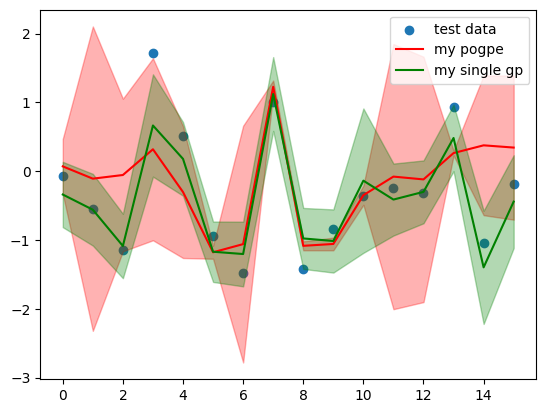

In [248]:
plt.scatter(range(len(X_test)),y_test, label = "test data")
plt.plot(ymu_tst_svi,label = "my pogpe",color="red")
plt.fill_between(range(len(X_test)),ymu_tst_svi+2*samples_posterior_predictive["std_fused"].mean(0),
                 ymu_tst_svi-2*samples_posterior_predictive["std_fused"].mean(0),alpha=0.3,color="red")
plt.plot(test_preds.mean.numpy(), label = "my single gp",color="green")
plt.fill_between(range(len(X_test)),test_preds.mean.numpy()+2*np.sqrt(test_preds.variance.numpy()),
                 test_preds.mean.numpy()-2*np.sqrt(test_preds.variance.numpy()),alpha=0.3,color="green")

plt.legend();

In [ ]:
_